In [34]:
#Import Libraries to use
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [21]:
# Load the cleaned CSVs for each country
benin = pd.read_csv('../data/benin_clean.csv')
sierra = pd.read_csv('../data/sierraleone-bumbuna_clean.csv')
togo = pd.read_csv('../data/togo-dapaong_qc_clean.csv')

In [22]:
benin['Country'] = 'Benin'
sierra['Country'] = 'Sierra Leone'
togo['Country'] = 'Togo'

# Combine all into one DataFrame
df_all = pd.concat([benin, sierra, togo], ignore_index=True)

In [23]:
# Ensure GHI, DNI, DHI columns exist (case-insensitive)
for col in ['GHI','DNI','DHI']:
    found = [c for c in df_all.columns if c.strip().lower()==col.lower()]
    if not found:
        raise ValueError(f"{col} column not found. Columns present: {df.columns.tolist()}")
print("All required metric columns found.")

All required metric columns found.


In [ ]:
def plot_metric_distributions(df, metrics, group_col='Country'):
    """
    Plots boxplots of given metrics grouped by a specified column.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        metrics (list): A list of column names (strings) to plot.
        group_col (str): The column name to group by (default: 'Country').
    """
    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=False)

    if n == 1:
        axes = [axes]  # make iterable for consistency

    for ax, metric in zip(axes, metrics):
            sns.boxplot(x=group_col, y=metric, data=df, ax=ax, palette='Set2')
            ax.set_title(f"{metric} by {group_col}")
            ax.set_xlabel("")
            ax.set_ylabel(metric)

    plt.tight_layout()
    plt.show()


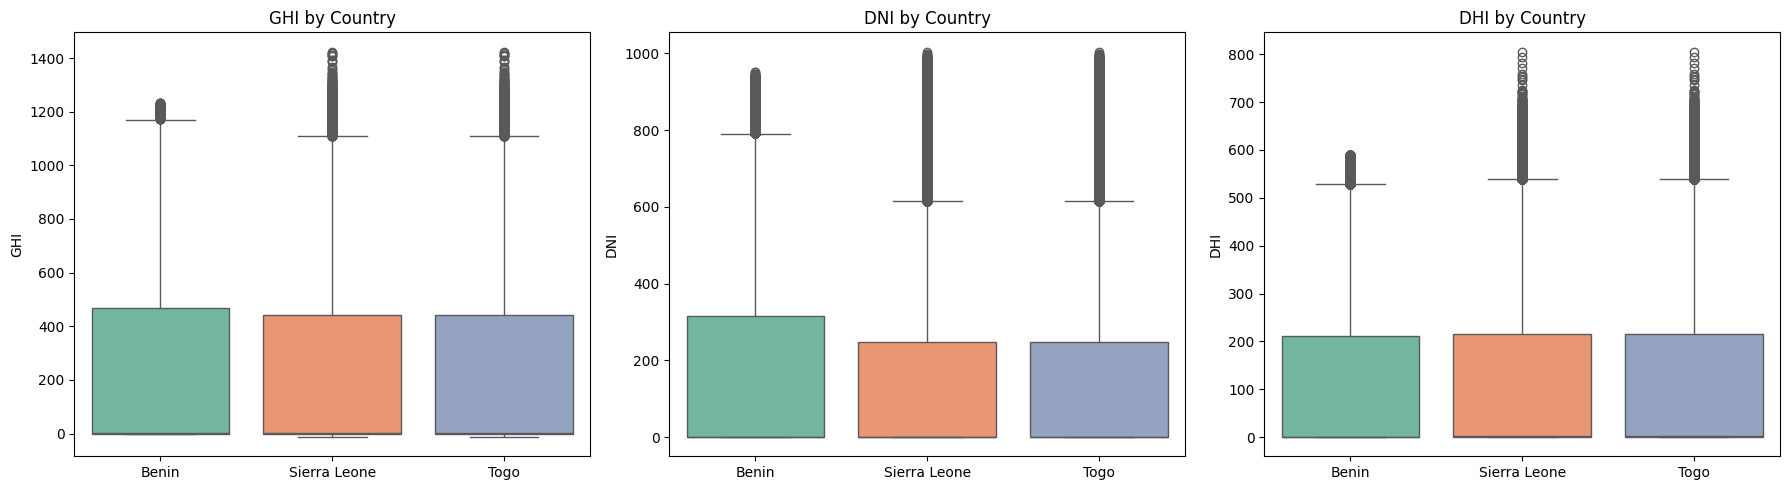

In [27]:
metrics = ['GHI', 'DNI', 'DHI']
plot_metric_distributions(df_all, metrics)

In [28]:
summary = df_all.groupby('Country')[metrics].agg(['mean', 'median', 'std']).round(2)
summary

GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         237.48    0.6  327.17  167.14    0.0  261.94  113.17    0.4   
Sierra Leone  230.56    2.1  322.53  151.26    0.0  250.96  116.44    2.5   
Togo          230.56    2.1  322.53  151.26    0.0  250.96  116.44    2.5   

                      
                 std  
Country               
Benin         151.66  
Sierra Leone  156.52  
Togo          156.52

In [29]:
# # Run ANOVA for GHI
# f_stat, p_value = f_oneway(
#     benin['GHI'].dropna(),
#     sierra['GHI'].dropna(),
#     togo['GHI'].dropna()
# )

# print(f"ANOVA results — F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")
def run_anova(column_name, **datasets):
    """
    Perform a one-way ANOVA test on the given column across multiple datasets.

    Parameters:
        column_name (str): The column to compare across datasets.
        **datasets: Variable number of named pandas DataFrames, e.g. benin=df1, sierra=df2.

    Returns:
        tuple: (F-statistic, p-value)
    """
    # Extract the column values and drop NaNs
    data_groups = [df[column_name].dropna() for df in datasets.values()]
    
    # Run ANOVA
    f_stat, p_value = f_oneway(*data_groups)
    
    # Display results
    
    
    return f_stat, p_value

In [30]:
f_stat, p_value = run_anova('GHI' ,benin=benin, sierra=sierra, togo=togo)
print(f"ANOVA results for 'GHI' — F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

ANOVA results for 'GHI' — F-statistic: 79.30, p-value: 0.0000


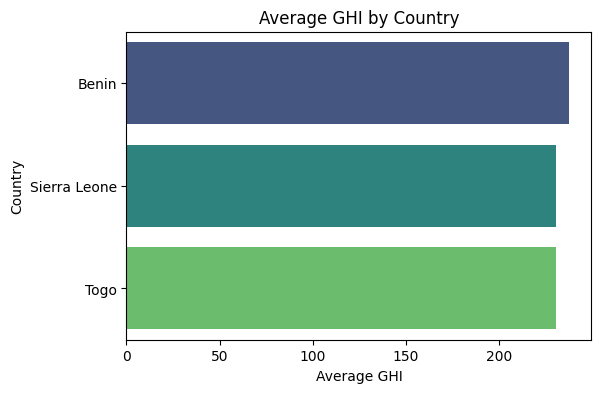

In [9]:
#Bar chart ranking countries by average GHI
avg_ghi = df_all.groupby('Country')['GHI'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=avg_ghi.values, y=avg_ghi.index, palette='viridis')
plt.title('Average GHI by Country')
plt.xlabel('Average GHI')
plt.ylabel('Country')
plt.show()

In [36]:
ghi_b = df_all.loc[df_all['Country']=='Benin', 'GHI'].dropna()
ghi_s = df_all.loc[df_all['Country']=='Sierra Leone', 'GHI'].dropna()
ghi_t = df_all.loc[df_all['Country']=='Togo', 'GHI'].dropna()

# 1) Check normality (Shapiro) and variance homogeneity (Levene) quickly
sh_b = stats.shapiro(ghi_b.sample(n=min(500, len(ghi_b)))) if len(ghi_b)>=3 else (None,None)
sh_s = stats.shapiro(ghi_s.sample(n=min(500, len(ghi_s)))) if len(ghi_s)>=3 else (None,None)
sh_t = stats.shapiro(ghi_t.sample(n=min(500, len(ghi_t)))) if len(ghi_t)>=3 else (None,None)
levene = stats.levene(ghi_b, ghi_s, ghi_t, center='median')

print("Shapiro p-values (Benin, Sierra Leone, Togo):",
      getattr(sh_b, 'pvalue', sh_b[1] if isinstance(sh_b, tuple) else None),
      getattr(sh_s, 'pvalue', sh_s[1] if isinstance(sh_s, tuple) else None),
      getattr(sh_t, 'pvalue', sh_t[1] if isinstance(sh_t, tuple) else None))
print("Levene test p-value (equal variances?):", levene.pvalue)

# If normality and homogeneity pass, do one-way ANOVA
anova_res = stats.f_oneway(ghi_b, ghi_s, ghi_t)
print("\nOne-way ANOVA result:")
print(f"F = {anova_res.statistic:.4f}, p-value = {anova_res.pvalue:.4e}")

# If assumptions fail (p < 0.05), do Kruskal-Wallis non-parametric test
if anova_res.pvalue < 0.05 or levene.pvalue < 0.05:
    kw = stats.kruskal(ghi_b, ghi_s, ghi_t)
    print("\nKruskal–Wallis result (non-parametric fallback):")
    print(f"H = {kw.statistic:.4f}, p-value = {kw.pvalue:.4e}")

Shapiro p-values (Benin, Sierra Leone, Togo): 5.241637296826533e-27 1.2371767806245545e-27 7.428998025539873e-27
Levene test p-value (equal variances?): 3.1896615775261933e-16

One-way ANOVA result:
F = 79.3001, p-value = 3.6486e-35

Kruskal–Wallis result (non-parametric fallback):
H = 62973.5255, p-value = 0.0000e+00


- Benin shows the **highest median GHI** (value: X) — but variability is moderate; useful for mid-scale solar projects.
- Sierra Leone displays the **lowest median DNI** and high variability in DHI, suggesting diffuse irradiance dominates in some seasons.
- Togo ranks second in mean GHI but shows the **largest spread** in GHI values (high std), indicating site-level variability; recommend site-specific measurements before deployment.
